In [1]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [2]:
import os

# 현재 작업 디렉토리 출력
print("현재 작업 디렉토리:", os.getcwd())

# 원하는 로컬 경로로 작업 디렉토리 변경
local_path = 'C:\\Users\\munbe\\BDA_Data_analysis'
os.chdir(local_path)

# 변경된 작업 디렉토리 출력
print("변경된 작업 디렉토리:", os.getcwd())


현재 작업 디렉토리: C:\Users\munbe\BDA_Data_analysis
변경된 작업 디렉토리: C:\Users\munbe\BDA_Data_analysis


In [3]:
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
SEED = 42

In [4]:
!pwd

/c/Users/munbe/BDA_Data_analysis


In [5]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
train_data

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,TRAIN_96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,TRAIN_96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,TRAIN_96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,TRAIN_96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [6]:
train_data.drop(columns=['ID'], inplace=True)

test_data=test_data.iloc[:,1:]
train_data

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [7]:
test_data

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0
3,14400000,36 months,5 years,MORTGAGE,66000000,13.72,30,신용 카드,1,669024,281724.0,0.0,0.0
4,27600000,36 months,5 years,RENT,55200000,30.50,12,신용 카드,0,1250052,614844.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,30000000,36 months,3 years,MORTGAGE,78000000,22.08,27,부채 통합,2,1307532,763380.0,0.0,0.0
64193,30000000,60 months,10+ years,MORTGAGE,109200000,12.06,26,부채 통합,0,960612,1245252.0,0.0,0.0
64194,6120000,36 months,10+ years,RENT,39600000,28.80,33,부채 통합,0,131520,80880.0,0.0,0.0
64195,11520000,36 months,10+ years,MORTGAGE,66000000,25.44,41,부채 통합,1,1339536,601872.0,0.0,0.0


In [8]:
# 데이터 탐색
display(train_data.head())
display(train_data.info())
display(train_data.describe())
# 결측치 확인
display(train_data.isnull().sum())

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   대출금액          96294 non-null  int64  
 1   대출기간          96294 non-null  object 
 2   근로기간          96294 non-null  object 
 3   주택소유상태        96294 non-null  object 
 4   연간소득          96294 non-null  int64  
 5   부채_대비_소득_비율   96294 non-null  float64
 6   총계좌수          96294 non-null  int64  
 7   대출목적          96294 non-null  object 
 8   최근_2년간_연체_횟수  96294 non-null  int64  
 9   총상환원금         96294 non-null  int64  
 10  총상환이자         96294 non-null  float64
 11  총연체금액         96294 non-null  float64
 12  연체계좌수         96294 non-null  float64
 13  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(5)
memory usage: 10.3+ MB


None

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
dtype: int64

In [9]:
train_data['대출금액'].value_counts()

12000000    6662
14400000    5826
24000000    5744
18000000    5582
42000000    4473
            ... 
33630000       1
37560000       1
41520000       1
41730000       1
39450000       1
Name: 대출금액, Length: 1340, dtype: int64

In [10]:
train_data.value_counts('근로기간')

근로기간
10+ years    31585
2 years       8450
< 1 year      7774
3 years       7581
1 year        6249
Unknown       5671
5 years       5665
4 years       5588
8 years       4888
6 years       3874
7 years       3814
9 years       3744
10+years       896
<1 year        370
3               89
1 years         56
dtype: int64

In [11]:
test_data.value_counts('근로기간')

근로기간
10+ years    20937
2 years       5609
< 1 year      5143
3 years       5036
1 year        4235
5 years       3927
Unknown       3862
4 years       3662
8 years       3284
9 years       2545
7 years       2515
6 years       2479
10+years       616
<1 year        259
3               49
1 years         39
dtype: int64

C:\Users\munbe\AppData\Local\Temp\ipykernel_9064\3239878948.py:18: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  plt.tight_layout()
C:\Users\munbe\AppData\Local\Temp\ipykernel_9064\3239878948.py:18: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from current font.
  plt.tight_layout()
C:\Users\munbe\AppData\Local\Temp\ipykernel_9064\3239878948.py:18: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  plt.tight_layout()
C:\Users\munbe\AppData\Local\Temp\ipykernel_9064\3239878948.py:18: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  plt.tight_layout()
C:\Users\munbe\AppData\Local\Temp\ipykernel_9064\3239878948.py:18: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  plt.tight_layout()
C:\Users\munbe\AppData\Local\Temp\ipykernel_9064\3239878948.py:18: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  plt.tight_layout()
C:\U

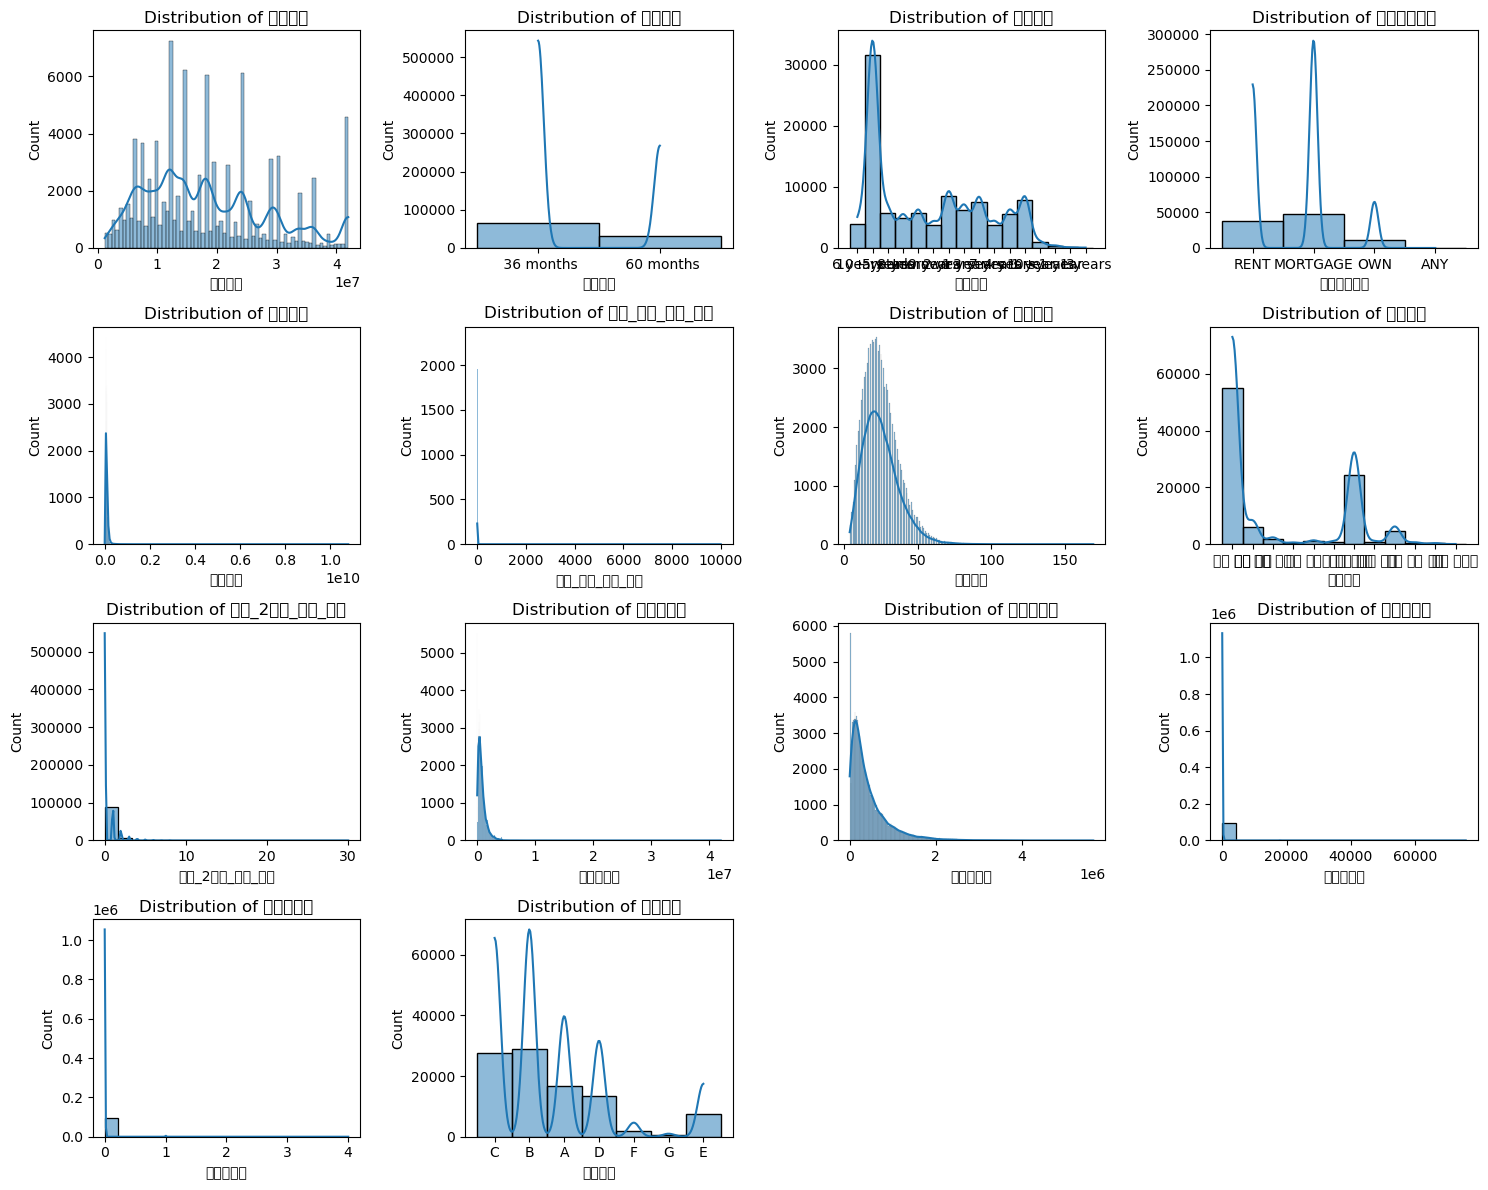

In [12]:
import math
num_cols = ['대출금액', '대출기간', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '총계좌수', '대출목적',
       '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '대출등급']

# 그래프의 크기 및 행, 열 설정
num_cols_count = len(num_cols)
num_cols_per_row = 4  # 각 행당 그래프 수를 조절
num_rows = int(math.ceil(num_cols_count / num_cols_per_row))

plt.figure(figsize=(15, 3 * num_rows))

for i, feature in enumerate(num_cols, 1):
    plt.subplot(num_rows, num_cols_per_row, i)
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')

# 그래프 출력
plt.tight_layout()
plt.show()

# 근로기간 데이터 전처리
- 유사 근로기간은 통합 시킴 1,3
- 그다음은 라벨 인코딩 및 원핫 인코딩 진행
- 주변 값을 이용해 Unkown을 처리 할것

In [13]:
train_data.loc[train_data['근로기간']=='3','근로기간']='3 years'
test_data.loc[test_data['근로기간']=='3','근로기간']='3 years'
test_data.loc[test_data['근로기간']=='1 year','근로기간']='1 years'
train_data.loc[train_data['근로기간']=='1 year','근로기간']='1 years'
test_data.loc[test_data['근로기간']=='<1 year','근로기간']='< 1 year'
train_data.loc[train_data['근로기간']=='<1 year','근로기간']='< 1 year'
test_data.loc[test_data['근로기간']=='10+years','근로기간']='10+ years'
train_data.loc[train_data['근로기간']=='10+years','근로기간']='10+ years'

In [14]:
train_data.value_counts('근로기간')

근로기간
10+ years    32481
2 years       8450
< 1 year      8144
3 years       7670
1 years       6305
Unknown       5671
5 years       5665
4 years       5588
8 years       4888
6 years       3874
7 years       3814
9 years       3744
dtype: int64

In [15]:
train_data['근로기간'].unique().tolist()
values_map=dict({'6 years':6,
 '10+ years':10,
 '5 years':5,
 '8 years':8,
 '9 years':9,
 '2 years':2,
 '1 years':1,
 '3 years':3,
 '7 years':7,
 '4 years':4,
 '< 1 year':0,
 'Unknown':np.NaN})

In [16]:
train_data['근로기간']=train_data['근로기간'].map(values_map)
test_data['근로기간']=test_data['근로기간'].map(values_map)

#### Encoding

In [17]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(handle_unknown='ignore')
col=['대출기간','주택소유상태','대출목적','연체계좌수','최근_2년간_연체_횟수','총계좌수']

In [18]:
enc.fit(train_data[col])
encoded_data = enc.fit_transform(train_data[col]).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=enc.get_feature_names_out(col))
train_data = train_data.drop(columns=['주택소유상태','대출목적']).join(encoded_df)
train_data['대출기간'] = train_data['대출기간'].str.strip().replace('months', '', regex=True).astype(float)

train_data

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,총계좌수_106,총계좌수_109,총계좌수_110,총계좌수_112,총계좌수_125,총계좌수_127,총계좌수_130,총계좌수_140,총계좌수_151,총계좌수_169
0,12480000,36.0,6.0,72000000,18.90,15,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14400000,60.0,10.0,130800000,22.33,21,0,373572,234060.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12000000,36.0,5.0,96000000,8.60,14,0,928644,151944.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14400000,36.0,8.0,132000000,15.09,15,0,325824,153108.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18000000,60.0,NaN,71736000,25.39,19,0,228540,148956.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36.0,10.0,210000000,9.33,33,0,974580,492168.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96290,28800000,60.0,10.0,132000000,5.16,25,0,583728,855084.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96291,14400000,36.0,1.0,84000000,11.24,22,0,1489128,241236.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96292,15600000,36.0,5.0,66330000,17.30,21,2,1378368,818076.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
encoded_test_data = enc.transform(test_data[col]).toarray()
encoded_test_df = pd.DataFrame(encoded_test_data, columns=enc.get_feature_names_out(col))
test_data = test_data.drop(columns=['주택소유상태','대출목적']).join(encoded_test_df)
test_data['대출기간'] = test_data['대출기간'].str.strip().replace('months', '', regex=True).astype(float)

test_data

,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,...,총계좌수_106,총계좌수_109,총계좌수_110,총계좌수_112,총계좌수_125,총계좌수_127,총계좌수_130,총계좌수_140,총계좌수_151,총계좌수_169
0,16800000,36.0,8.0,132000000,19.64,12,0,394692,146604.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8400000,36.0,5.0,89971200,15.84,25,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17280000,36.0,6.0,150000000,8.41,20,0,1786980,281820.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14400000,36.0,5.0,66000000,13.72,30,1,669024,281724.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27600000,36.0,5.0,55200000,30.50,12,0,1250052,614844.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64192,30000000,36.0,3.0,78000000,22.08,27,2,1307532,763380.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64193,30000000,60.0,10.0,109200000,12.06,26,0,960612,1245252.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64194,6120000,36.0,10.0,39600000,28.80,33,0,131520,80880.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64195,11520000,36.0,10.0,66000000,25.44,41,1,1339536,601872.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 트리를 사용한  근로기간 NaN 채워주기 시작

In [20]:
train_data.isnull().sum()[train_data.isnull().sum()>0],test_data.isnull().sum()[test_data.isnull().sum()>0]

(근로기간    5671
 dtype: int64,
 근로기간    3862
 dtype: int64)

In [21]:
### Case 1 NULL 값 행 다 삭제
### NULL 값이 있는 행 삭제
## train_data = train_data.dropna()
## test_data = test_data.dropn()

In [22]:
# '근로기간' 열의 결측값을 해당 열의 평균 값으로 채우기
mean_value = train_data['근로기간'].mean()
train_data['근로기간'].fillna(mean_value, inplace=True)

In [23]:
display(train_data.isnull().sum())

대출금액           0
대출기간           0
근로기간           0
연간소득           0
부채_대비_소득_비율    0
              ..
총계좌수_127       0
총계좌수_130       0
총계좌수_140       0
총계좌수_151       0
총계좌수_169       0
Length: 163, dtype: int64

In [24]:
train_data['근로기간'].value_counts()

10.000000    32481
2.000000      8450
0.000000      8144
3.000000      7670
1.000000      6305
6.007791      5671
5.000000      5665
4.000000      5588
8.000000      4888
6.000000      3874
7.000000      3814
9.000000      3744
Name: 근로기간, dtype: int64

In [25]:
# Assuming s_columns is your original list of Korean column names
s_columns = ['대출금액', '대출기간', '근로기간', '주택소유상태', '연간소득', '부채_대비_소득_비율', '총계좌수', '대출목적', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']

# Mapping dictionary for translation
translation_dict = {
    '대출금액': 'LoanAmount',
    '대출기간': 'LoanPeriod',
    '근로기간': 'EmploymentPeriod',
    '주택소유상태': 'HomeOwnershipStatus',
    '연간소득': 'AnnualIncome',
    '부채_대비_소득_비율': 'DebtToIncomeRatio',
    '총계좌수': 'TotalAccounts',
    '대출목적': 'LoanPurpose',
    '최근_2년간_연체_횟수': 'Recent2YearsDelinquencyCount',
    '총상환원금': 'TotalRepaymentPrincipal',
    '총상환이자': 'TotalRepaymentInterest',
    '총연체금액': 'TotalDelinquentAmount',
    '연체계좌수': 'DelinquentAccounts'
}

# Rename the columns using the mapping dictionary
train_data.rename(columns=translation_dict, inplace=True)
test_data.rename(columns=translation_dict, inplace=True)

Model Tune for lgbm.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1659
[LightGBM] [Info] Number of data points in the train set: 96294, number of used features: 115
[LightGBM] [Info] Start training from score -1.747695
[LightGBM] [Info] Start training from score -1.206441
[LightGBM] [Info] Start training from score -1.248757
[LightGBM] [Info] Start training from score -1.975590
[LightGBM] [Info] Start training from score -2.572162
[LightGBM] [Info] Start training from score -3.897527
[LightGBM] [Info] Start training from score -5.434907


C:\Users\munbe\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\munbe\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\munbe\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51340 (\N{HANGUL SYLLABLE JWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\munbe\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\munbe\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\munbe\anaconda3

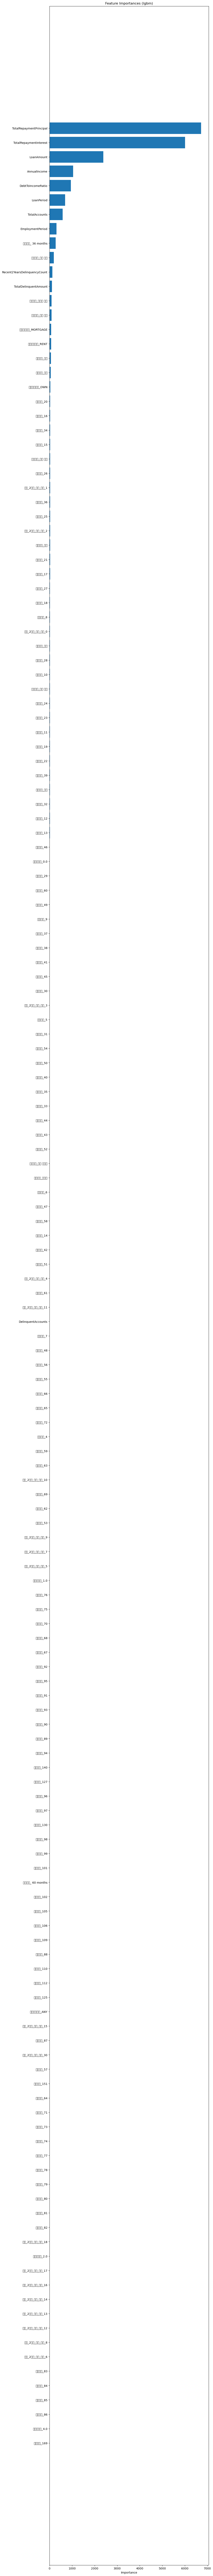

In [26]:
def train_and_evaluate(model, model_name, train_x, train_y, importance_threshold=100):
    print(f'Model Tune for {model_name}.')
    model.fit(train_x, train_y)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(train_x.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(train_x.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(train_x.shape[1]), train_x.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    # Gather column names with importance less than the threshold
    less_than_threshold = train_x.columns[sorted_idx][feature_importances[sorted_idx] < 10].tolist()

    return model, feature_importances, less_than_threshold

train_x = train_data.drop(columns=['대출등급'])
train_y = train_data['대출등급']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances, less_than_threshold_columns = train_and_evaluate(
    LGBMClassifier(), 'lgbm', train_x, train_y
)


In [27]:
lgbm_feature_importances

array([2384,  695,  311, 1050,  949,  584,  132, 6717, 6012,  109,    4,
        270,    0,    0,   78,   42,   76,   69,   91,   94,  194,   18,
         25,    7,    7,   22,   59,   30,   22,   14,    1,    0,    0,
         23,   28,   26,   10,    5,    1,    0,    1,    0,    1,    2,
          4,    0,    0,    0,    0,    0,    0,    0,    0,    3,   10,
          6,    4,   23,   12,   22,   20,   17,   16,    6,   32,   33,
         25,   24,   19,   33,   25,   19,   21,   22,   26,   28,   24,
         22,   13,   10,   10,   17,    8,   32,    8,   26,   11,   11,
         18,    9,   11,    6,    7,    7,   11,   15,    6,    4,   13,
          9,    6,    7,    2,    9,    3,    4,    0,    6,    3,   13,
          5,    2,    3,    0,    3,    3,    1,    1,    2,    1,    0,
          3,    0,    0,    1,    1,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [28]:
trans_train_x = train_x.drop(columns=less_than_threshold_columns)
trans_test_data = test_data.drop(columns=less_than_threshold_columns)
trans_train_x

,LoanAmount,LoanPeriod,EmploymentPeriod,AnnualIncome,DebtToIncomeRatio,TotalAccounts,Recent2YearsDelinquencyCount,TotalRepaymentPrincipal,TotalRepaymentInterest,TotalDelinquentAmount,...,총계좌수_34,총계좌수_36,총계좌수_37,총계좌수_38,총계좌수_39,총계좌수_41,총계좌수_45,총계좌수_46,총계좌수_49,총계좌수_60
0,12480000,36.0,6.000000,72000000,18.90,15,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14400000,60.0,10.000000,130800000,22.33,21,0,373572,234060.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12000000,36.0,5.000000,96000000,8.60,14,0,928644,151944.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14400000,36.0,8.000000,132000000,15.09,15,0,325824,153108.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18000000,60.0,6.007791,71736000,25.39,19,0,228540,148956.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36.0,10.000000,210000000,9.33,33,0,974580,492168.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96290,28800000,60.0,10.000000,132000000,5.16,25,0,583728,855084.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96291,14400000,36.0,1.000000,84000000,11.24,22,0,1489128,241236.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96292,15600000,36.0,5.000000,66330000,17.30,21,2,1378368,818076.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
trans_train = train_data.drop(columns=less_than_threshold_columns)
trans_train.to_csv('scaled_train.csv', index=False, encoding='utf-8')
trans_test_data.to_csv('scaled_test.csv', index=False, encoding='utf-8')

## 전처리 데이터 불러서하기

In [30]:
train_data=pd.read_csv('scaled_train.csv')
test_data=pd.read_csv('scaled_test.csv')

In [31]:
trans_train_x = train_data.drop(columns='대출등급')
train_y = train_data['대출등급']

### Voting

In [32]:
cat_clf = CatBoostClassifier(silent=True)
lgb_clf = LGBMClassifier()
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [33]:
class CustomCatBoostClassifier(CatBoostClassifier):
    def predict(self, X, **kwargs):
        predictions = super().predict(X, **kwargs)

        return np.ravel(predictions)

In [34]:
cat_clf = CustomCatBoostClassifier(silent=True)

lgb_clf = LGBMClassifier()
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

In [35]:
voting_clf = VotingClassifier(
    estimators=[('cat', cat_clf), ('lgb', lgb_clf), ('xgb', xgb_clf)],
    voting='hard'
)
voting_clf.fit(trans_train_x, train_y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 96294, number of used features: 64
[LightGBM] [Info] Start training from score -1.747695
[LightGBM] [Info] Start training from score -1.206441
[LightGBM] [Info] Start training from score -1.248757
[LightGBM] [Info] Start training from score -1.975590
[LightGBM] [Info] Start training from score -2.572162
[LightGBM] [Info] Start training from score -3.897527
[LightGBM] [Info] Start training from score -5.434907


VotingClassifier(estimators=[('cat',
                              <__main__.CustomCatBoostClassifier object at 0x000001C81B9DA490>),
                             ('lgb', LGBMClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_...
                                            grow_policy=None,
                                            importance_type=None,
                              

#### Lstm _ensemble

In [36]:
pip install google-colab

  Using cached google-colab-1.0.0.tar.gz (72 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached google_auth-1.4.2-py2.py3-none-any.whl (64 kB)
  Using cached ipykernel-4.6.1-py3-none-any.whl (104 kB)
  Using cached ipython-5.5.0-py3-none-any.whl (758 kB)
  Using cached notebook-5.2.2-py2.py3-none-any.whl (8.0 MB)
  Using cached six-1.12.0-py2.py3-none-any.whl (10 kB)
  Using cached pandas-0.24.2.tar.gz (11.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): still running...
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [324 lines of output]
  C:\Users\munbe\AppData\Local\Temp\pip-install-2i7ez0hl\pandas_f611c5262a064771856f0cc7b06d82ba\setup.py:12: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
    import pkg_resources
  C:\Users\munbe\AppData\Local\Temp\pip-install-2i7ez0hl\pandas_f611c5262a064771856f0cc7b06d82ba\setup.py:50: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
    _CYTHON_INSTALLED = ver >= LooseVersion(min_cython_ver)
  performance hint: pandas\_libs\hashing.pyx:98:5: Exception check on 'u32to8_le' will always require the GIL to be acquired.
  Possible solutions:
          1. Declare 'u32to8_le' as 'noexcept' if you control the definition and you're sure you don't want the function to raise exceptions.
          2. Use an 'int' return type on 'u32to8_le' to a

In [37]:
import google.colab

ModuleNotFoundError: No module named 'google'

In [ ]:
# Displaying all column names to identify any time-related features
features = train_data.columns.tolist()
from tensorflow.keras.models import Sequential

In [ ]:
# 레이블 인코더 생성
encoder = LabelEncoder()
# train_y 레이블 인코딩
categorical_target = encoder.fit_transform(train_y)
# 인코딩된 레이블 출력 (옵션)
print(categorical_target)
# 원래 레이블과 인코딩된 레이블 매핑
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_mapping)

from keras.layers import Concatenate, Attention
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization


# 모델 입력을 위한 특성 수 설정 (타겟 변수를 제외한 나머지 특성 수)
num_features = trans_train_x.shape[1]

# 첫 번째 LSTM 브랜치
input1 = Input(shape=(num_features, 1))
lstm_branch1 = LSTM(50, return_sequences=True)(input1)
lstm_branch1 = BatchNormalization()(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)
lstm_branch1 = LSTM(50)(lstm_branch1)
lstm_branch1 = Dropout(0.2)(lstm_branch1)

# 두 번째 LSTM 브랜치
input2 = Input(shape=(num_features, 1))
lstm_branch2 = LSTM(60, return_sequences=True)(input2)
lstm_branch2 = BatchNormalization()(lstm_branch2)
lstm_branch2 = Dropout(0.3)(lstm_branch2)
lstm_branch2 = LSTM(52, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)
lstm_branch2 = LSTM(50, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.4)(lstm_branch2)
lstm_branch2 = LSTM(57, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)
lstm_branch2 = LSTM(52, return_sequences=True)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)
lstm_branch2 = LSTM(49)(lstm_branch2)
lstm_branch2 = Dropout(0.2)(lstm_branch2)

# 세 번째 LSTM 브랜치
input3 = Input(shape=(num_features, 1))
lstm_branch3 = LSTM(55, return_sequences=True)(input3)
lstm_branch3 = BatchNormalization()(lstm_branch3)
lstm_branch3 = Dropout(0.2)(lstm_branch3)
lstm_branch3 = LSTM(55, return_sequences=True)(lstm_branch3)
lstm_branch3 = Dropout(0.3)(lstm_branch3)
lstm_branch3 = LSTM(60, return_sequences=True)(lstm_branch3)
lstm_branch3 = Dropout(0.3)(lstm_branch3)
lstm_branch3 = LSTM(60, return_sequences=True)(lstm_branch3)
lstm_branch3 = Dropout(0.2)(lstm_branch3)
lstm_branch3 = LSTM(50)(lstm_branch3)
lstm_branch3 = Dropout(0.2)(lstm_branch3)

# Attention 레이어
# LSTM 브랜치들의 출력을 Attention 레이어에 연결
attention_layer = Attention()([lstm_branch1, lstm_branch2, lstm_branch3])

# 앙상블 모델
concatenated = Concatenate()([attention_layer, lstm_branch1, lstm_branch2, lstm_branch3])
dense1 = Dense(64, activation='relu')(concatenated)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense2)
output = Dense(7, activation='softmax')(dropout2)  # 7개 클래스에 대한 softmax 출력

ensemble_model = Model(inputs=[input1, input2, input3], outputs=output)

# 모델 컴파일
ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
ensemble_model.summary()


In [ ]:
train_X, val_X, train_y, val_y = train_test_split(
    trans_train_x,
    train_y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=train_y
)

In [ ]:
train_X_1 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_2 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
train_X_3 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)

val_X_1 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_2 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
val_X_3 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)

test_X_1 = trans_test_data.values.reshape(trans_test_data.shape[0], trans_test_data.shape[1], 1)
test_X_2 = trans_test_data.values.reshape(trans_test_data.shape[0], trans_test_data.shape[1], 1)
test_X_3 = trans_test_data.values.reshape(trans_test_data.shape[0], trans_test_data.shape[1], 1)


In [ ]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from keras.models import save_model, load_model

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표: 검증 손실
    patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
    restore_best_weights=True  # 최적의 모델 가중치로 복원
)

# 모델 학습
history = ensemble_model.fit(
    [train_X_1, train_X_2, train_X_3],
    train_y,
    epochs=100,
    batch_size=32,
    validation_data=([val_X_1, val_X_2, val_X_3], val_y),
    callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
)


In [ ]:
# from keras.layers import Concatenate, Attention
# from keras.models import Model
# from keras.layers import Input, LSTM, Dropout, Dense, BatchNormalization

# # 첫 번째 LSTM 브랜치
# input1 = Input(shape=(trans_train_x.shape[1], 1))
# lstm_branch1 = LSTM(50, return_sequences=True)(input1)
# lstm_branch1 = BatchNormalization()(lstm_branch1)
# lstm_branch1 = Dropout(0.2)(lstm_branch1)
# lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
# lstm_branch1 = Dropout(0.2)(lstm_branch1)
# lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
# lstm_branch1 = Dropout(0.2)(lstm_branch1)
# lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
# lstm_branch1 = Dropout(0.2)(lstm_branch1)
# lstm_branch1 = LSTM(50, return_sequences=True)(lstm_branch1)
# lstm_branch1 = Dropout(0.2)(lstm_branch1)
# lstm_branch1 = LSTM(50)(lstm_branch1)
# lstm_branch1 = Dropout(0.2)(lstm_branch1)

# # 두 번째 LSTM 브랜치
# input2 = Input(shape=(trans_train_x.shape[1], 1))
# lstm_branch2 = LSTM(60, return_sequences=True)(input2)
# lstm_branch2 = BatchNormalization()(lstm_branch2)
# lstm_branch2 = Dropout(0.3)(lstm_branch2)
# lstm_branch2 = LSTM(52, return_sequences=True)(lstm_branch2)
# lstm_branch2 = Dropout(0.2)(lstm_branch2)
# lstm_branch2 = LSTM(50, return_sequences=True)(lstm_branch2)
# lstm_branch2 = Dropout(0.4)(lstm_branch2)
# lstm_branch2 = LSTM(57, return_sequences=True)(lstm_branch2)
# lstm_branch2 = Dropout(0.2)(lstm_branch2)
# lstm_branch2 = LSTM(52, return_sequences=True)(lstm_branch2)
# lstm_branch2 = Dropout(0.2)(lstm_branch2)
# lstm_branch2 = LSTM(49)(lstm_branch2)
# lstm_branch2 = Dropout(0.2)(lstm_branch2)

# # 세 번째 LSTM 브랜치
# input3= Input(shape=(trans_train_x.shape[1], 1))
# lstm_branch3 = LSTM(55, return_sequences=True)(input3)
# lstm_branch3 = BatchNormalization()(lstm_branch3)
# lstm_branch3 = Dropout(0.2)(lstm_branch3)
# lstm_branch3 = LSTM(55, return_sequences=True)(lstm_branch3)
# lstm_branch3 = Dropout(0.3)(lstm_branch3)
# lstm_branch3 = LSTM(60, return_sequences=True)(lstm_branch3)
# lstm_branch3 = Dropout(0.3)(lstm_branch3)
# lstm_branch3 = LSTM(60, return_sequences=True)(lstm_branch3)
# lstm_branch3 = Dropout(0.2)(lstm_branch3)
# lstm_branch3 = LSTM(50)(lstm_branch3)
# lstm_branch3 = Dropout(0.2)(lstm_branch3)

# # Attention 레이어
# attention_layer = Attention()([lstm_branch1, lstm_branch2, lstm_branch3])

# # 앙상블 모델
# concatenated = Concatenate()([attention_layer, lstm_branch1, lstm_branch2, lstm_branch3])
# dense1 = Dense(64)(concatenated)
# dropout1 = Dropout(0.2)(dense1)
# dense2 = Dense(32)(dropout1)
# dropout2 = Dropout(0.2)(dense2)
# output = Dense(7, activation='softmax')(dropout2)  # 클래스 수에 맞추어 출력 뉴런 수 조정, 활성화 함수를 'softmax'로 설정


# ensemble_model = Model(inputs=[input1, input2, input3], outputs=output)
# ensemble_model.summary()
# ensemble_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
# from sklearn.preprocessing import LabelEncoder

# # 레이블 인코더 생성
# encoder = LabelEncoder()

# # train_y 레이블 인코딩
# train_y_encoded = encoder.fit_transform(train_y)

# # 인코딩된 레이블 출력 (옵션)
# print(train_y_encoded)

# # 원래 레이블과 인코딩된 레이블 매핑
# label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
# print(label_mapping)

In [ ]:
# train_X, val_X, train_y, val_y = train_test_split(
#     trans_train_x,
#     train_y_encoded,
#     test_size=0.2,
#     random_state=42,
#     shuffle=True,
#     stratify=train_y
# )

In [ ]:
# train_X_1 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
# train_X_2 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)
# train_X_3 = train_X.values.reshape(train_X.shape[0], train_X.shape[1], 1)

# val_X_1 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
# val_X_2 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)
# val_X_3 = val_X.values.reshape(val_X.shape[0], val_X.shape[1], 1)

# test_X_1 = trans_test_data.values.reshape(trans_test_data.shape[0], trans_test_data.shape[1], 1)
# test_X_2 = trans_test_data.values.reshape(trans_test_data.shape[0], trans_test_data.shape[1], 1)
# test_X_3 = trans_test_data.values.reshape(trans_test_data.shape[0], trans_test_data.shape[1], 1)


In [ ]:
# # 학습 중 모델의 학습 결과를 저장할 파일명

# from keras.callbacks import EarlyStopping
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
# from keras.models import save_model, load_model

# # EarlyStopping 콜백 설정
# early_stopping = EarlyStopping(
#     monitor='val_loss',  # 모니터링할 지표: 검증 손실
#     patience=5,  # 지정된 epoch 동안 개선이 없을 경우 조기 종료
#     restore_best_weights=True  # 최적의 모델 가중치로 복원
# )

#     # validation_data=([val_X_1, val_X_2, val_X_3], val_y),

# # 앙상블 모델 학습
# history = ensemble_model.fit(
#     [train_X_1, train_X_2, train_X_3],
#     train_y,
#     validation_data=([val_X_1, val_X_2, val_X_3], val_y),
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stopping]  # EarlyStopping 콜백만 추가
# )


In [ ]:
# predicted_labels = model.predict(some_data) # 모델로부터 예측 결과 얻기
# original_labels = encoder.inverse_transform(predicted_labels) # 원래 레이블로 변환
# print(original_labels)

In [ ]:
pred_rf = ensemble_model.predict([test_X_1, test_X_2, test_X_3])
pred_rf_classes = np.argmax(pred_rf, axis=1)  # 가장 높은 확률을 가진 클래스로 변환

In [ ]:
original_labels = encoder.inverse_transform(pred_rf_classes) # 원래 레이블로 변환
print(original_labels)

In [ ]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('sample_submission.csv')
submission.head()

In [ ]:
len(original_labels)

In [ ]:
submission['대출등급'] = original_labels
submission.head()

In [ ]:
submission.to_csv('01_30_lstm_ensemble_submission.csv',index = False)

#### 기계학습 모델과 딥러닝 모델 앙상블하기

In [ ]:
lstm_predictions = ensemble_model.predict(train_x)
cat_predictions = cat_clf.predict(trans_train_x)

In [ ]:
predict_vot = voting_clf.predict(trans_test_data)

In [ ]:
# 새로운 feature set 생성
stacked_features = np.column_stack((lstm_predictions, predict_vot))

# 3단계: 메타 모델 학습
# 메타 모델로 로지스틱 회귀 또는 다른 모델을 사용할 수 있음
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
meta_model.fit(stacked_features, train_y)

In [ ]:
# 제출용 sample 파일불러오기
submission = pd.read_csv('sample_submission.csv')
submission.head()

In [ ]:
submission['대출등급'] =  y_pred
submission.head()

In [ ]:
submission.to_csv('01_29_lgbm_submission.csv',index = False)

In [ ]:
# # Assuming you want to exclude non-numeric columns
# numeric_columns = train_data.select_dtypes(include=[np.number])

# # Calculate correlation matrix
# correlation_matrix = numeric_columns.corr()

# # Visualize the correlation matrix
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.show()


In [ ]:
# # Assuming you want to exclude non-numeric columns
# numeric_columns = train_data.select_dtypes(include=[np.number])

# # Print column names
# print("Numeric Columns:", numeric_columns.columns)

# # Calculate correlation matrix
# correlation_matrix = numeric_columns.corr()

# # Visualize the correlation matrix
# plt.figure(figsize=(15, 15))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
# plt.show()
